In [89]:
import pandas as pd
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
raw_data = pd.read_csv('data/Kobe.csv')

In [3]:
raw_data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

Удаляем строки с пустым целевым атрибутом:

In [6]:
data = raw_data.dropna(subset=['shot_made_flag']).reset_index()

Преобразуем в нормальное время:

In [7]:
data['dt_game_date'] = pd.to_datetime(data['game_date'])

Добавим переменных 

In [8]:

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 30 columns):
index                     25697 non-null int64
action_type               25697 non-null object
combined_shot_type        25697 non-null object
game_event_id             25697 non-null int64
game_id                   25697 non-null int64
lat                       25697 non-null float64
loc_x                     25697 non-null int64
loc_y                     25697 non-null int64
lon                       25697 non-null float64
minutes_remaining         25697 non-null int64
period                    25697 non-null int64
playoffs                  25697 non-null int64
season                    25697 non-null object
seconds_remaining         25697 non-null int64
shot_distance             25697 non-null int64
shot_made_flag            25697 non-null float64
shot_type                 25697 non-null object
shot_zone_area            25697 non-null object
shot_zone_basic           25697 no

Строчек с пустыми атрибутами нет - прекрасно.

In [10]:
data.describe()

,index,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart
count,25697.000000,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000
mean,15327.166946,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946,321.519321,398.480679,1487.556446
std,8860.462397,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397,208.311076,208.311076,851.005173
min,1.000000,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000,0.000000,6.000000,6.000000
25%,7645.000000,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000,141.000000,221.000000,709.000000
50%,15335.000000,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000,304.000000,416.000000,1502.000000
75%,22975.000000,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000,499.000000,579.000000,2160.000000
max,30696.000000,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000,714.000000,720.000000,3766.000000


In [11]:
data['coord'] = data['lat'].astype(str) + ', ' + data['lon'].astype(str)
data.coord.value_counts()

34.0443, -118.2698    4321
34.0433, -118.2698      16
34.0443, -118.2708       9
34.0433, -118.2688       8
34.0433, -118.2518       7
34.0443, -118.2848       6
33.9813, -118.2688       6
34.0443, -118.2678       6
34.0443, -118.1108       6
34.0443, -118.2858       6
34.0303, -118.2528       5
34.0323, -118.2468       5
34.0403, -118.2588       5
34.0383, -118.2528       5
33.9343, -118.1318       5
34.0413, -118.2718       5
34.0353, -118.2698       5
34.0443, -118.1208       5
33.9833, -118.2348       5
33.9123, -118.1618       5
34.0443, -118.2468       5
33.8353, -118.4278       5
34.0143, -118.1948       5
34.0333, -118.2738       5
34.0323, -118.2498       5
34.0443, -118.1288       5
33.8583, -118.4468       5
34.0443, -118.2718       5
34.0383, -118.2628       5
34.0403, -118.2858       5
                      ... 
34.0133, -118.3618       1
34.0183, -118.2928       1
33.8753, -118.4168       1
33.7173, -118.0818       1
34.0043, -118.3088       1
33.8803, -118.3548       1
3

На координаты расчитывать не стоит - некоторые из них указывают в море-окиян

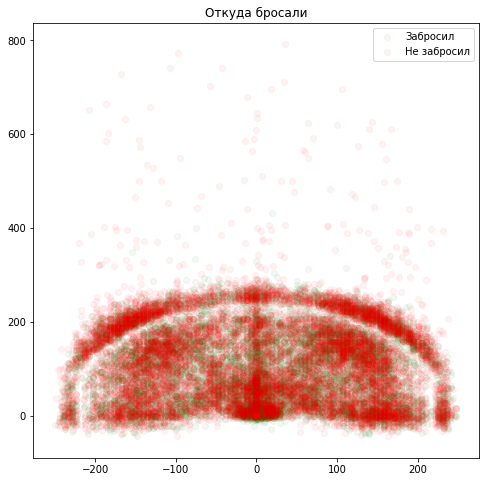

In [93]:
sm = data[data['shot_made_flag'] == 1]
nsm = data[data['shot_made_flag'] == 0]
alpha = 0.05
plt.figure(figsize=(8, 8))
plt.scatter(sm.loc_x, sm.loc_y, color='green', alpha=alpha, label='Забросил')
plt.scatter(nsm.loc_x, nsm.loc_y, color='red', alpha=alpha, label='Не забросил')
plt.title('Откуда бросали')
plt.legend()

Как видно по графику - чем ближе к корзине, тем вероятнее забросить.

В тестовый набор поместим наиболее поздние броски

In [13]:
def split_train_test(data, test_ratio):
    test_count = round(len(data) * test_ratio)
    train_count = len(data) - test_count
    return data.sort_values(by=['dt_game_date', 'secondsFromGameStart'], ascending=False).tail(train_count).reset_index(), \
           data.sort_values(by=['dt_game_date', 'secondsFromGameStart'], ascending=False).head(test_count).reset_index()
           

In [14]:
train_data, test_data = split_train_test(data, 0.2)
len(train_data), len(test_data)

(20558, 5139)

### Опредляем, с какими фичами будем работать

Разделяем признаки на числовые и категориальные, оставляем только явно полезные для нас признаки

In [15]:
num_columns = ['loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs', 'seconds_remaining', 'shot_distance',
               'secondsFromPeriodEnd', 'secondsFromPeriodStart', 'secondsFromGameStart']
cat_columns = ['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
               'opponent']

Так как мы разделили выборку по времни, части могут быть не сбалансированы, поэтому категориальные переменные будем изучать на общем наборе данных

Получим список значений для всех категорий, для OneHotEncoder-а

In [16]:
def get_cat_categories(df, cat_columns):
    categories = []
    for column in cat_columns:
        categories.append(list(df[column].unique()))    
    return categories

In [17]:
categories = get_cat_categories(data, cat_columns)

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=categories), cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    sparse_threshold=0,
    remainder='drop'
)

In [20]:
def get_feature_names(column_transformer, df):
    feature_names = []
    for _, tr, columns in column_transformer.transformers:
        if type(tr).__name__ == 'OneHotEncoder':
            tr.fit(df[columns]) # wtf?? удивительно, но факт, но ColumnTransformer сначала клонирует незафиченный трансформер, а потом его выполняет
            feature_names.extend(list(tr.get_feature_names(columns)))
        elif type(tr).__name__ == 'StandardScaler':
            feature_names.extend(columns)
        else:
            raise RuntimeError(f'Unknown class: {type(tr).__name__}, plrase update function')
    return feature_names

In [21]:
feature_names = get_feature_names(preprocessor, train_data)

In [22]:
len(feature_names)

124

Итого у нас 124 фичи

Вообще, линейная регрессия для задачи бинарной классификации называется логистической регрессией, но в задании сказано линейная регрессия, значит линейная регрессия.

Пробуем простую линейную регрессию

In [23]:
X = preprocessor.fit_transform(data)
y = np.array(data['shot_made_flag'])

/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
clf_lin = LinearRegression()

In [25]:
clf_lin.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
y_pred_lin = clf_lin.predict(X)

In [28]:
lin_mse = mean_squared_error(y, y_pred_lin)
lin_rmse = np.sqrt(lin_mse)

In [35]:
print(f'RMSE: {lin_rmse}')
print(f'Intercept: {clf_lin.intercept_}')
print(f'R^2: {clf_lin.score(X, y)}')
print(f'RSS: {sum((y_pred_lin - y) ** 2)}')

RMSE: 0.458325727148906
Intercept: 110599057569.81714
R^2: 0.1498935189591717
RSS: 5397.975347264437


Пробуем лассо. Можно было бы поиграться альфой, но в рамках этой задачи возьмем значение по умолчанию.

In [31]:
clf_lasso = Lasso()
clf_lasso.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
y_pred_lasso = clf_lasso.predict(X)
lasso_mse = mean_squared_error(y, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)

In [36]:
print(f'RMSE: {lasso_rmse}')
print(f'Intercept: {clf_lasso.intercept_}')
print(f'R^2: {clf_lasso.score(X, y)}')
print(f'RSS: {sum((y_pred_lasso - y) ** 2)}')

RMSE: 0.49709291421222224
Intercept: 0.44616103047048294
R^2: 0.0
RSS: 6349.763785655984


Теперь ридж, опять в дефолтовой конфигурации

In [37]:
clf_ridge = Ridge()
clf_ridge.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [38]:
y_pred_ridge = clf_ridge.predict(X)
ridge_mse = mean_squared_error(y, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)

In [39]:
print(f'RMSE: {ridge_rmse}')
print(f'Intercept: {clf_ridge.intercept_}')
print(f'R^2: {clf_ridge.score(X, y)}')
print(f'RSS: {sum((y_pred_ridge - y) ** 2)}')

RMSE: 0.4582593160605801
Intercept: 0.6237396601953923
R^2: 0.15013986082043196
RSS: 5396.411134634894


Посмотрим, что у нас с коэффициентами в моделях.

In [42]:
df_coef = pd.DataFrame()
df_coef['Features'] = pd.Series(feature_names)
df_coef['LinearRegression'] = clf_lin.coef_
df_coef['Lasso'] = clf_lasso.coef_
df_coef['Ridge'] = clf_ridge.coef_

In [51]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
df_coef

,Features,LinearRegression,Lasso,Ridge
0,action_type_Jump Shot,4.556257e+10,-0.0,-0.341644
1,action_type_Driving Dunk Shot,2.237797e+11,0.0,0.105976
2,action_type_Layup Shot,-2.434033e+10,-0.0,-0.281306
3,action_type_Running Jump Shot,4.556257e+10,0.0,0.105347
4,action_type_Reverse Dunk Shot,2.237797e+11,0.0,0.044793
5,action_type_Slam Dunk Shot,2.237797e+11,0.0,0.112088
6,action_type_Driving Layup Shot,-2.434033e+10,0.0,0.077043
7,action_type_Turnaround Jump Shot,4.556257e+10,0.0,-0.058921
8,action_type_Reverse Layup Shot,-2.434033e+10,0.0,-0.030007
9,action_type_Tip Shot,1.590853e+12,-0.0,-0.049908


Для простой линейной регрессии большинство коэффициентов имеет огромное значение, что объясняет гигантский intersept. Модель явно переобучена.

Лассо модель прибила все коэффициенты и считает, что Коби всегда мажет.

Ридж регрессия выглядиет более адекватной, нежели первые две. Кстати, по знаку перед коэффициентом можно трактовать полезность фичи - есль коэффициент положительный, то этот фактор способствует попданию, если отрицательный - способствует промаху.

### Попробуем обучить модели на части данных и проверить на тесте.

In [56]:
X_train = preprocessor.fit_transform(train_data)
y_train = np.array(train_data['shot_made_flag'])

/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [57]:
X_test = preprocessor.fit_transform(test_data)
y_test = np.array(test_data['shot_made_flag'])

/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### LinearRegression

In [95]:
clf_lin_test = LinearRegression()
clf_lin_test.fit(X_train, y_train)
y_pred_lin_test = clf_lin.predict(X_test)
y_pred_lin_train = clf_lin.predict(X_train)
lin_mse_test = mean_squared_error(y_test, y_pred_lin_test)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_roc_auc_test = roc_auc_score(y_test, y_pred_lin_test)
lin_roc_auc_train = roc_auc_score(y_train, y_pred_lin_train)

In [97]:
print(f'RMSE: {lin_rmse_test}')
print(f'Intercept: {clf_lin_test.intercept_}')
print(f'R^2: {clf_lin_test.score(X_test, y_test)}')
print(f'RSS: {sum((y_pred_lin_test - y_test) ** 2)}')
print(f'ROC AUC test: {lin_roc_auc_test}')
print(f'ROC AUC train: {lin_roc_auc_train}')

RMSE: 4729670924.93634
Intercept: -205916820387.39005
R^2: -1.366315574181631e+21
RSS: 1.1495833569202893e+23
ROC AUC test: 0.48350282538659295
ROC AUC train: 0.520304347527205


In [91]:
lin_fpr_train, lin_tpr_train, _ = roc_curve(y_train, y_pred_lin_train)
lin_fpr_test, lin_tpr_test, _ = roc_curve(y_test, y_pred_lin_test)

In [101]:
def plt_roc_auc(title, fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC {roc_auc_train}')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC {roc_auc_test}')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()    

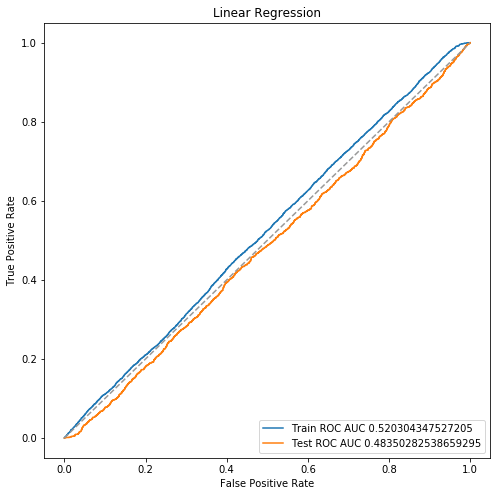

In [102]:
plt_roc_auc('Linear Regression', lin_fpr_train, lin_tpr_train, lin_roc_auc_train, lin_fpr_test, lin_tpr_test, lin_roc_auc_test)

Как и ожидалось, на тестовых данных модель будет абсолютно невменяема.

#### Lasso

In [108]:
clf_lasso_test = Lasso()
clf_lasso_test.fit(X_train, y_train)
y_pred_lasso_train = clf_lasso_test.predict(X_train)
y_pred_lasso_test = clf_lasso_test.predict(X_test)
lasso_mse_test = mean_squared_error(y_test, y_pred_lasso_test)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_roc_auc_train = roc_auc_score(y_test, y_pred_lasso_test)
lasso_roc_auc_test = roc_auc_score(y_test, y_pred_lasso_test)

In [109]:
print(f'RMSE: {lasso_rmse_test}')
print(f'Intercept: {clf_lasso_test.intercept_}')
print(f'R^2: {clf_lasso_test.score(X_test, y_test)}')
print(f'RSS: {sum((y_pred_lasso_test - y_test) ** 2)}')
print(f'ROC AUC train: {lasso_roc_auc_train}')
print(f'ROC AUC test: {lasso_roc_auc_test}')

RMSE: 0.4944384817099362
Intercept: 0.4533514933359276
R^2: -0.00531617724269462
RSS: 1256.3283092732638
ROC AUC train: 0.5
ROC AUC test: 0.5


In [110]:
lasso_fpr_train, lasso_tpr_train, _ = roc_curve(y_train, y_pred_lasso_train)
lasso_fpr_test, lasso_tpr_test, _ = roc_curve(y_test, y_pred_lasso_test)

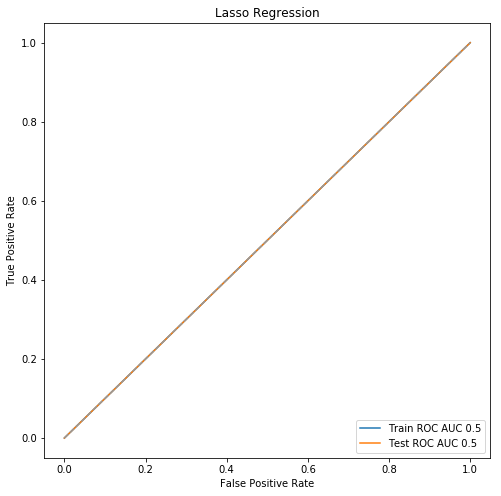

In [117]:
plt_roc_auc('Lasso Regression', lasso_fpr_train, lasso_tpr_train, lasso_roc_auc_train, lasso_fpr_test, lasso_tpr_test, lasso_roc_auc_test)

Отрицательный R^2 и ROC AUC в 0.5 как бы намекают нам.

#### Ridge

In [115]:
clf_ridge_test = Ridge()
clf_ridge_test.fit(X_train, y_train)
y_pred_ridge_train = clf_ridge_test.predict(X_train)
y_pred_ridge_test = clf_ridge_test.predict(X_test)
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge_test)
ridge_rmse_test = np.sqrt(ridge_mse_test)
ridge_roc_auc_train = roc_auc_score(y_train, y_pred_ridge_train)
ridge_roc_auc_test = roc_auc_score(y_test, y_pred_ridge_test)

In [116]:
print(f'RMSE: {ridge_rmse_test}')
print(f'Intercept: {clf_ridge_test.intercept_}')
print(f'R^2: {clf_ridge_test.score(X_test, y_test)}')
print(f'RSS: {sum((y_pred_ridge_test - y_test) ** 2)}')
print(f'ROC AUC train: {ridge_roc_auc_train}')
print(f'ROC AUC test: {ridge_roc_auc_test}')

RMSE: 0.4696637922053097
Intercept: 0.6405534859046491
R^2: 0.09290598046173582
RSS: 1133.5815753448678
ROC AUC train: 0.7049089128546845
ROC AUC test: 0.6799659925912431


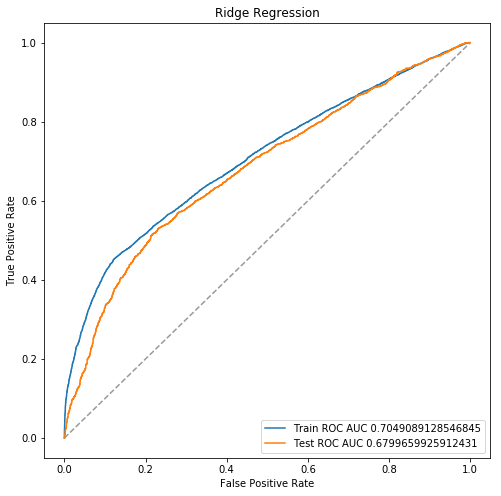

In [118]:
ridge_fpr_train, ridge_tpr_train, _ = roc_curve(y_train, y_pred_ridge_train)
ridge_fpr_test, ridge_tpr_test, _ = roc_curve(y_test, y_pred_ridge_test)
plt_roc_auc('Ridge Regression', ridge_fpr_train, ridge_tpr_train, ridge_roc_auc_train, ridge_fpr_test, ridge_tpr_test, ridge_roc_auc_test)

Как и ожидалось, ридж дала хоть какой-то вменяемый результат.

### PCA

In [68]:
pca = PCA(n_components=len(feature_names))
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=124, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [75]:
for i in range(1, 21):
    print(f'components: {i}, explained variance ratio: {sum(pca.explained_variance_ratio_[:i])}')

components: 1, explained variance ratio: 0.2270628388735411
components: 2, explained variance ratio: 0.41236702913152434
components: 3, explained variance ratio: 0.5391960907166216
components: 4, explained variance ratio: 0.6173954231331509
components: 5, explained variance ratio: 0.6870422663884999
components: 6, explained variance ratio: 0.7554961012974556
components: 7, explained variance ratio: 0.8125804981802246
components: 8, explained variance ratio: 0.8392460120361392
components: 9, explained variance ratio: 0.8609983489769881
components: 10, explained variance ratio: 0.8726974482818609
components: 11, explained variance ratio: 0.8823281352231218
components: 12, explained variance ratio: 0.8901482715088262
components: 13, explained variance ratio: 0.89647506318058
components: 14, explained variance ratio: 0.9023579067615674
components: 15, explained variance ratio: 0.9073141673259186
components: 16, explained variance ratio: 0.911600979270023
components: 17, explained variance 

Первые 9 компонент объясняют более 85% модели